In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from src.helpers import extract_files
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_columns',40)
pd.set_option('display.float_format','{:.2f}'.format)

In [ ]:
#Extract raw data from github and save into the project folder using a helper function.
#Limit firsrt 2 rows for inspection...
url = "https://raw.githubusercontent.com/LuxDevHQ/Sales_Performance_-_Decision_Making_Using_Statistics/refs/heads/main/statistics_sales_project_data.csv"
destination = "../data/01-raw"
filename = "statistics_sales_project_data.csv"
raw_sales_data = extract_files(url, destination, filename)
raw_sales_data.head(2)

Destination: ..\data\01-raw\statistics_sales_project_data.csv
Data size: 49,542 bytes (0.05 MB)
Success! File 'statistics_sales_project_data.csv' saved to ../data/01-raw
Loading File into DataFrame...


,date,store_type,region,marketing_campaign,units_sold,revenue
0,2023-01-01,Online,Western,Yes,6,11876.03
1,2023-01-02,Physical,Rift Valley,Yes,8,14333.00


In [17]:
#inspect raw data, number of rows and columns
def shape(df_):
    print(f"Shape of DataFrame: {df_.shape}")
    return df_
shape(raw_sales_data)

Shape of DataFrame: (1200, 6)


,date,store_type,region,marketing_campaign,units_sold,revenue
0,2023-01-01,Online,Western,Yes,6,11876.03
1,2023-01-02,Physical,Rift Valley,Yes,8,14333.00
2,2023-01-03,Physical,Western,No,4,8101.97
3,2023-01-04,Physical,Coast,No,8,10928.92
4,2023-01-05,Online,Nairobi,No,9,18166.40
...,...,...,...,...,...,...
1195,2026-04-10,Physical,Coast,No,9,19206.49
1196,2026-04-11,Physical,Rift Valley,Yes,2,4469.23
1197,2026-04-12,Physical,Rift Valley,No,5,8560.56
1198,2026-04-13,Physical,Central,No,6,8324.26


In [18]:
(raw_sales_data
 .info()
)


<class 'pandas.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1200 non-null   str    
 1   store_type          1200 non-null   str    
 2   region              1200 non-null   str    
 3   marketing_campaign  1200 non-null   str    
 4   units_sold          1200 non-null   int64  
 5   revenue             1200 non-null   float64
dtypes: float64(1), int64(1), str(4)
memory usage: 56.4 KB


In [23]:
#Convert the 'date' column to datetime and extract year-month.

sales_data =(raw_sales_data
.assign(date =  lambda df_ : pd.to_datetime(df_.date))
.assign(year_month = lambda df_: df_.date.dt.to_period('M'))
)
sales_data.head(2)

,date,store_type,region,marketing_campaign,units_sold,revenue,year_month
0,2023-01-01,Online,Western,Yes,6,11876.03,2023-01
1,2023-01-02,Physical,Rift Valley,Yes,8,14333.00,2023-01


In [24]:
#Get summary statistics for all numeric columns
#Pass include ='all' to view other types. We can easily tell the count of the non-missing rows by inspecting count row.
#Findings -> No missing values in any column (all counts = 1200)
(sales_data
.describe(include = 'all')
 )

,date,store_type,region,marketing_campaign,units_sold,revenue,year_month
count,1200,1200,1200,1200,1200.00,1200.00,1200
unique,NaN,2,5,2,NaN,NaN,40
top,NaN,Physical,Rift Valley,No,NaN,NaN,2023-01
freq,NaN,661,270,753,NaN,NaN,31
mean,2024-08-22 12:00:00,NaN,NaN,NaN,4.98,8271.97,NaN
min,2023-01-01 00:00:00,NaN,NaN,NaN,0.00,0.00,NaN
25%,2023-10-27 18:00:00,NaN,NaN,NaN,3.00,5177.53,NaN
50%,2024-08-22 12:00:00,NaN,NaN,NaN,5.00,7723.32,NaN
75%,2025-06-18 06:00:00,NaN,NaN,NaN,6.00,10739.32,NaN
max,2026-04-14 00:00:00,NaN,NaN,NaN,15.00,26885.87,NaN


**PART 1**: Descriptive Statistics (Chapter 2)
```
Task 1.1 – Central Tendency
```
For monthly revenue:
Calculate:

- Mean
- Median
- Mode

Explain which measure best represents revenue and why (consider outliers).

---

In [54]:
central_tendency_analysis = (sales_data
    .assign(year_month=lambda df: df["date"].dt.to_period("M"))
    .groupby("year_month", as_index=False)

    .agg(monthly_revenue=("revenue", "sum"))
    
    .assign(mean_val=lambda df: float(df["monthly_revenue"].mean()),
        median_val=lambda df: float(df["monthly_revenue"].median()),
        mode_val=lambda df: float(df["monthly_revenue"].mode().iloc[0])
        if not df["monthly_revenue"].mode().empty
        else np.nan,
        skewness_val=lambda df: float(df["monthly_revenue"].skew()),
        iqr=lambda df: df["monthly_revenue"].quantile(0.75)
        - df["monthly_revenue"].quantile(0.25),
        outlier_flag=lambda df: ((df["monthly_revenue"] < (df["monthly_revenue"].quantile(0.25) - 1.5 * df["iqr"]) )
            | ( df["monthly_revenue"] > (df["monthly_revenue"].quantile(0.75) + 1.5 * df["iqr"]))),)

    .pipe(lambda df: {"mean": df["mean_val"].iloc[0],
            "median": df["median_val"].iloc[0],
            "mode": df["mode_val"].iloc[0],
            "skewness": df["skewness_val"].iloc[0],
            "outlier_percent": (df["outlier_flag"].sum() / len(df)) * 100,
            "percent_diff": (
                (df["mean_val"].iloc[0] - df["median_val"].iloc[0])/ df["median_val"].iloc[0] ) * 100,"recommendation": "median"
            if abs( (  (df["mean_val"].iloc[0] - df["median_val"].iloc[0])  / df["median_val"].iloc[0])* 100 )> 10 else "mean",})
)

#results
print(f"Mean Monthly Revenue:    KES {central_tendency_analysis['mean']:,.2f}")
print(f"Median Monthly Revenue:  KES {central_tendency_analysis['median']:,.2f}")

if pd.isna(central_tendency_analysis["mode"]):
    print("Mode Monthly Revenue:    No unique mode")
else:
    print(f"Mode Monthly Revenue:    KES {central_tendency_analysis['mode']:,.2f}")

print(f"Skewness:                {central_tendency_analysis['skewness']:.2f}")
print(f"Outlier Percentage:      {central_tendency_analysis['outlier_percent']:.1f}%")
print(f"Mean-Median Difference:  {abs(central_tendency_analysis['percent_diff']):.1f}%")
print(
    f"\nRecommended Measure:      << {central_tendency_analysis['recommendation'].upper()} >>"
)


# Explanation based on results
print(f"\n-------------------------# EXPALATION #---------------------------------")
if central_tendency_analysis["recommendation"] == "median":
    print("The median is the preferred measure for this analysis because:")
    print("• Revenue figures are influenced by extreme values that distort the average (>10% diff).")
    print("• The median reflects the typical operating month more accurately.")
    print("• This provides a more conservative basis for decision-making.")
    print("• It is better suited for risk-aware planning and performance evaluation.")

else:
    print(f"\n• Monthly revenue figures are stable, with the mean closely aligned to the median (<10% diff).")
    print("• The revenue distribution shows limited distortion from extreme values.")
    print("• Using the mean provides a reliable representation of overall financial performance.")
    print("• This makes the mean suitable for budgeting, forecasting, and performance benchmarking.")


Mean Monthly Revenue:    KES 248,159.22
Median Monthly Revenue:  KES 250,308.55
Mode Monthly Revenue:    KES 105,774.81
Skewness:                -1.70
Outlier Percentage:      2.5%
Mean-Median Difference:  0.9%

Recommended Measure:      << MEAN >>

-------------------------# EXPALATION #---------------------------------

• Monthly revenue figures are stable, with the mean closely aligned to the median (<10% diff).
• The revenue distribution shows limited distortion from extreme values.
• Using the mean provides a reliable representation of overall financial performance.
• This makes the mean suitable for budgeting, forecasting, and performance benchmarking.


**Task 1.2** – Dispersion

```
Calculate:

Range
Variance
Standard deviation
```
**Answer**:

- What does high standard deviation imply about sales stability?
- Reference: Measures of Dispersion and Standard Deviation slides
---

In [56]:
#dispersion measures
dispersion_analysis = (
    sales_data.assign(year_month=lambda df: df["date"].dt.to_period("M"))
    .groupby("year_month", as_index=False)
    .agg(monthly_revenue=("revenue", "sum"))
    .pipe(
        lambda df: pd.Series(
            {
                "range": df["monthly_revenue"].max() - df["monthly_revenue"].min(),
                "variance": df["monthly_revenue"].var(ddof=0),  # Population variance
                "std_dev": df["monthly_revenue"].std(ddof=0),  # Population std dev
                "cv": (df["monthly_revenue"].std(ddof=0) / df["monthly_revenue"].mean())
                * 100,
                "iqr": df["monthly_revenue"].quantile(0.75)
                - df["monthly_revenue"].quantile(0.25),
                "mean": df["monthly_revenue"].mean(),
            }
        )
    )
)

# Format and display results
print("Dispersion Analysis - Monthly Revenue")
print(f"Range:             KES {dispersion_analysis['range']:,.2f}")
print(f"Variance:          KES {dispersion_analysis['variance']:,.2f}")
print(f"Standard Deviation: KES {dispersion_analysis['std_dev']:,.2f}")
print(f"Mean:              KES {dispersion_analysis['mean']:,.2f}")
print(f"Coefficient of Variation: {dispersion_analysis['cv']:.1f}%")
print(f"Interquartile Range (IQR): KES {dispersion_analysis['iqr']:,.2f}")

print("Interpretation of Standard deviation")
print("---------------------------------------")

#Determine sales stability based on CV thresholds
cv = dispersion_analysis["cv"]
mean = dispersion_analysis["mean"]
std_dev = dispersion_analysis["std_dev"]

if cv < 15:
    stability = "HIGH"
    explanation = f"""
    • Monthly revenue demonstrates strong consistency around the average level (KES {mean:,.0f}).
    • A standard deviation of KES {std_dev:,.0f} represents only {cv:.1f}% of the mean, indicating low volatility.
    • Revenue performance is predictable, supporting reliable forecasting.
    • The business enjoys stable cash flow patterns with minimal surprise deviations.
    • The business can plan budgets, staffing, and inventory with a high degree of confidence.
    """
elif cv < 30:
    stability = "MODERATE"
    explanation = f"""
    • Monthly revenue shows moderate fluctuations around the average level.
    • A standard deviation of KES {std_dev:,.0f} represents {cv:.1f}% of the mean.
    • Forecasts remain useful but should allow for reasonable variance.
    • Management should include contingency buffers in financial and operational planning.
    """
else:
    stability = "LOW"
    explanation = f"""
    • Monthly revenue is highly volatile, indicating inconsistent sales performance.
    • A standard deviation of KES {std_dev:,.0f} represents {cv:.1f}% of the mean.
    • Revenue forecasting is subject to significant uncertainty.
    • Strategic planning should prioritize risk mitigation, cash flow buffers, and flexible operations.
    """

print(f"Sales Stability: {stability}")
print(explanation)

# Empirical Rule application (for normally distributed data)
print("\nBusiness Interpretation:")
print("• These ranges provide management with probabilistic expectations of monthly revenue.")
print("• Most months are expected to fall within the 68% and 95% bands under normal conditions.")
print("• Values outside these ranges should be investigated as potential anomalies or exceptional events.")

# Compare dispersion to mean
print("\nManagement Insight:")
print(f"• Revenue volatility represents {std_dev/mean*100:.1f}% of the average monthly performance.")
print("• This ratio helps assess financial risk and the reliability of revenue-driven decisions.")

# Show actual min/max for context
monthly_summary = (
    sales_data.assign(year_month=lambda df: df["date"].dt.to_period("M"))
    .groupby("year_month", as_index=False)
    .agg(monthly_revenue=("revenue", "sum"))
)

print(f"\nActual Monthly Range:")
print(f"• Minimum:  KES {monthly_summary['monthly_revenue'].min():,.0f}")
print(f"• Maximum:  KES {monthly_summary['monthly_revenue'].max():,.0f}")
print(f"• Mean:     KES {mean:,.0f}")

Dispersion Analysis - Monthly Revenue
Range:             KES 198,603.55
Variance:          KES 1,169,956,760.24
Standard Deviation: KES 34,204.63
Mean:              KES 248,159.22
Coefficient of Variation: 13.8%
Interquartile Range (IQR): KES 31,050.40
Interpretation of Standard deviation
---------------------------------------
Sales Stability: HIGH

    • Monthly revenue demonstrates strong consistency around the average level (KES 248,159).
    • A standard deviation of KES 34,205 represents only 13.8% of the mean, indicating low volatility.
    • Revenue performance is predictable, supporting reliable forecasting.
    • The business enjoys stable cash flow patterns with minimal surprise deviations.
    • The business can plan budgets, staffing, and inventory with a high degree of confidence.
    

Business Interpretation:
• These ranges provide management with probabilistic expectations of monthly revenue.
• Most months are expected to fall within the 68% and 95% bands under normal 


**Task 1.3** – Shape of Distribution

```
Plot a histogram of revenue
```
Identify:
- Normal
- Positively skewed
- Negatively skewed
Comment on skewness and kurtosis

(Reference: Shapes of Distribution, Skewness and Kurtosis)

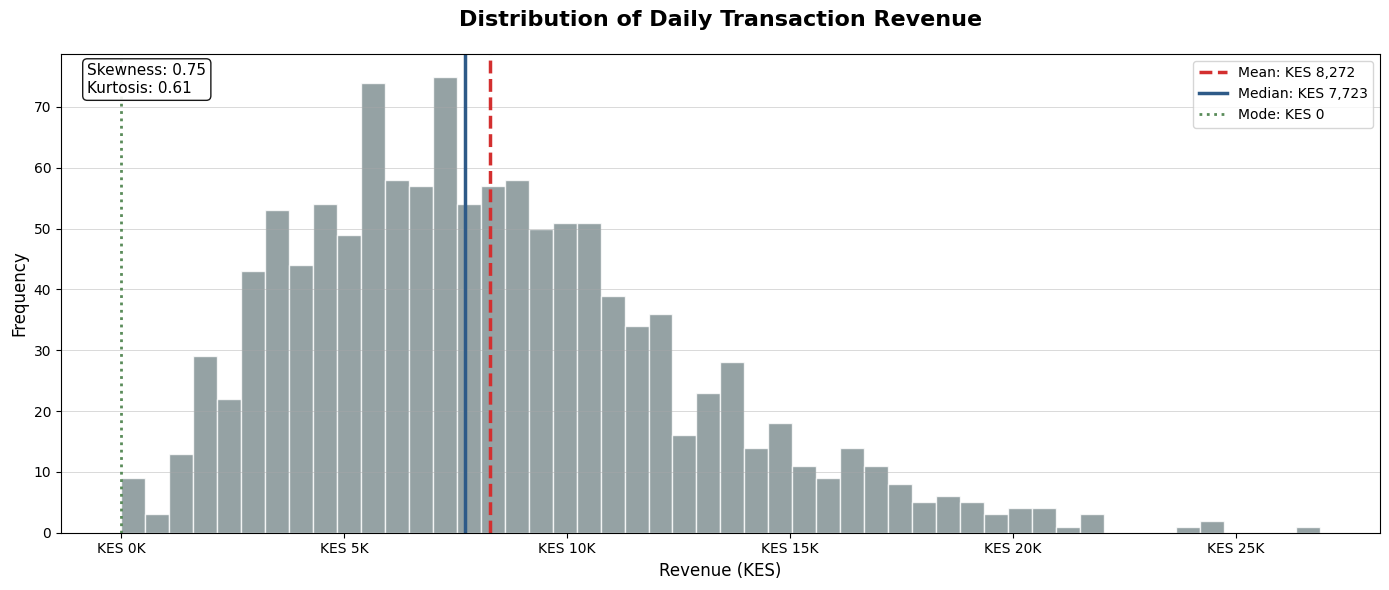

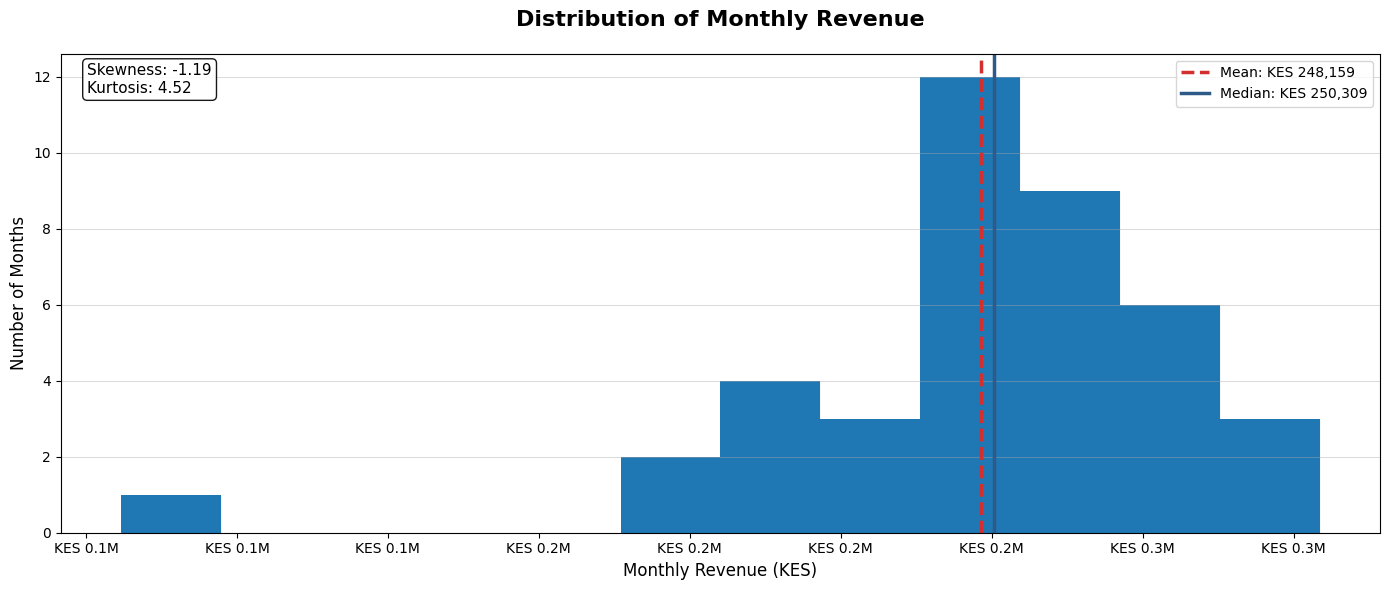

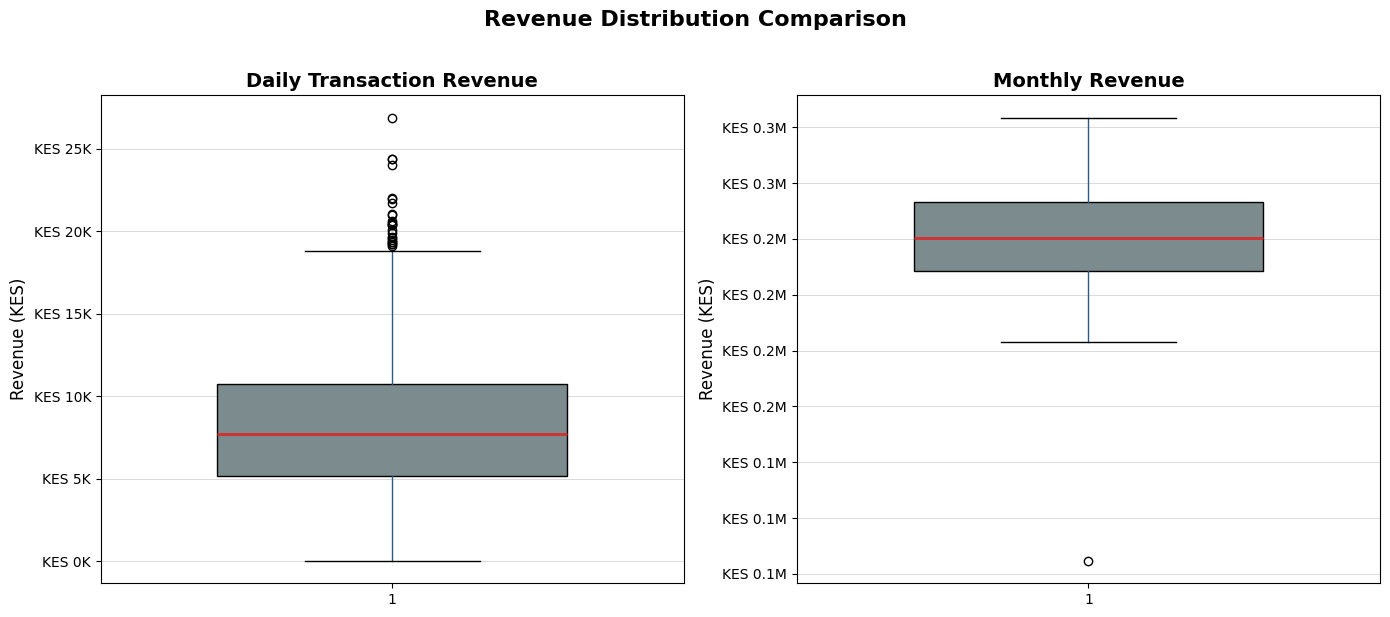

SHAPE OF DISTRIBUTION ANALYSIS
DAILY TRANSACTION REVENUE:
----------------------------------------
Skewness:  0.749
Kurtosis:  0.614
• Mean > Median by KES 549
• Shape: Positively skewed (right-tailed)
• Tail behavior: Mesokurtic (normal-like)

MONTHLY REVENUE:
----------------------------------------
Skewness:  -1.187
Kurtosis:  4.516
• Shape: Negatively skewed

BUSINESS IMPLICATIONS:
----------------------------------------
POSITIVE SKEW indicates:
• Most transactions are small/medium, with occasional large sales
• Business has growth potential through increasing average transaction size
• Risk: Revenue dependent on few large transactions

NORMAL-LIKE TAIL BEHAVIOR suggests:
• Moderate probability of extreme values
• Standard statistical methods are appropriate
• Balanced risk profile

RECOMMENDATION FOR STATISTICAL ANALYSIS:
----------------------------------------
⚠ Revenue distribution deviates from normality
✓ Consider non-parametric tests or data transformation
✓ Bootstrapping m

In [ ]:
def kes_millions_formatter(x, pos):
    """Format numbers as millions with 'M' suffix for KES"""
    return f"KES {x/1e6:.1f}M"

def kes_thousands_formatter(x, pos):
    """Format numbers as thousands with 'K' suffix for KES"""
    return f"KES {x/1000:.0f}K"

#Custom plotting colors
BLUE = "#2E5A88"
GRAY = "#7B8B8E"
GREEN = "#5A8C5A"
RED = "#D32F2F"
LIGHT_GRAY = "#F5F5F5"

#Calculate monthly revenue for analysis
monthly_revenue = (sales_data.assign(year_month=lambda df: df["date"].dt.to_period("M"))
    .groupby("year_month", as_index=False)
    .agg(monthly_revenue=("revenue", "sum"))
    )

#get distribution shape metrics
distribution_metrics = sales_data.assign(
    monthly_rev=lambda df: df.groupby(df["date"].dt.to_period("M"))["revenue" ].transform("sum")
    ).pipe(lambda df: pd.Series({ "daily_skew": df["revenue"].skew(),
            "daily_kurt": df["revenue"].kurtosis(),
            "monthly_skew": df["monthly_rev"].skew(),
            "monthly_kurt": df["monthly_rev"].kurtosis(),
            "daily_mean": df["revenue"].mean(),
            "daily_median": df["revenue"].median(),
            "monthly_mean": monthly_revenue["monthly_revenue"].mean(),
            "monthly_median": monthly_revenue["monthly_revenue"].median(),}))

# ======================= PLOT 1: DAILY REVENUE HISTOGRAM =======================
plt.figure(figsize=(14, 6))
bars = plt.hist( sales_data["revenue"], bins=50, color=GRAY, edgecolor="white", alpha=0.8)[2]

# Add mean and median lines
plt.axvline(
    distribution_metrics["daily_mean"],
    color=RED,
    linestyle="--",
    linewidth=2.5,
    label=f"Mean: KES {distribution_metrics['daily_mean']:,.0f}",
)
plt.axvline(
    distribution_metrics["daily_median"],
    color=BLUE,
    linestyle="-",
    linewidth=2.5,
    label=f"Median: KES {distribution_metrics['daily_median']:,.0f}",
)

# Calculate and plot mode (most frequent value range)
daily_mode = sales_data["revenue"].mode()
if not daily_mode.empty:
    plt.axvline(
        daily_mode.iloc[0],
        color=GREEN,
        linestyle=":",
        linewidth=2,
        label=f"Mode: KES {daily_mode.iloc[0]:,.0f}",
    )

plt.title("Distribution of Daily Transaction Revenue", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Revenue (KES)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(kes_thousands_formatter))
plt.grid(axis="y", alpha=0.6, linestyle="-", linewidth=0.5, color="darkgray")
plt.legend(loc="upper right", fontsize=10)

# Add skewness/kurtosis annotation
skew_text = f"Skewness: {distribution_metrics['daily_skew']:.2f}\nKurtosis: {distribution_metrics['daily_kurt']:.2f}"
plt.text(
    0.02,
    0.98,
    skew_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
)

plt.tight_layout()
plt.show()

# ======================= PLOT 2: MONTHLY REVENUE HISTOGRAM =======================
plt.figure(figsize=(14, 6))
bars = plt.hist(
    monthly_revenue["monthly_revenue"],
    bins=12,
    color=GRAY,
    edgecolor="white",
    alpha=0.8,
)[2]

# Color the mode bar differently if exists
monthly_mode = monthly_revenue["monthly_revenue"].mode()
if not monthly_mode.empty:
    mode_bin_index = (
        np.digitize(
            [monthly_mode.iloc[0]],
            plt.hist(monthly_revenue["monthly_revenue"], bins=12)[1],
        )[0]
        - 1
    )
    if mode_bin_index < len(bars):
        bars[mode_bin_index].set_facecolor(GREEN)

# Add mean and median lines
plt.axvline(
    distribution_metrics["monthly_mean"],
    color=RED,
    linestyle="--",
    linewidth=2.5,
    label=f"Mean: KES {distribution_metrics['monthly_mean']:,.0f}",
)
plt.axvline(
    distribution_metrics["monthly_median"],
    color=BLUE,
    linestyle="-",
    linewidth=2.5,
    label=f"Median: KES {distribution_metrics['monthly_median']:,.0f}",
)

plt.title("Distribution of Monthly Revenue", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Monthly Revenue (KES)", fontsize=12)
plt.ylabel("Number of Months", fontsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(kes_millions_formatter))
plt.grid(axis="y", alpha=0.6, linestyle="-", linewidth=0.5, color="darkgray")
plt.legend(loc="upper right", fontsize=10)

# Add skewness/kurtosis annotation
skew_text = f"Skewness: {distribution_metrics['monthly_skew']:.2f}\nKurtosis: {distribution_metrics['monthly_kurt']:.2f}"
plt.text(
    0.02,
    0.98,
    skew_text,
    transform=plt.gca().transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.9),
)

plt.tight_layout()
plt.show()

# ======================= PLOT 3: REVENUE DISTRIBUTION COMPARISON =======================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Daily Revenue Box Plot
daily_box = ax1.boxplot(
    sales_data["revenue"],
    patch_artist=True,
    widths=0.6,
    medianprops=dict(color=RED, linewidth=2),
)
daily_box["boxes"][0].set_facecolor(GRAY)
daily_box["whiskers"][0].set_color(BLUE)
daily_box["whiskers"][1].set_color(BLUE)
ax1.set_title("Daily Transaction Revenue", fontsize=14, fontweight="bold")
ax1.set_ylabel("Revenue (KES)", fontsize=12)
ax1.yaxis.set_major_formatter(FuncFormatter(kes_thousands_formatter))
ax1.grid(axis="y", alpha=0.6, linestyle="-", linewidth=0.5, color="darkgray")

# Monthly Revenue Box Plot
monthly_box = ax2.boxplot(
    monthly_revenue["monthly_revenue"],
    patch_artist=True,
    widths=0.6,
    medianprops=dict(color=RED, linewidth=2),
)
monthly_box["boxes"][0].set_facecolor(GRAY)
monthly_box["whiskers"][0].set_color(BLUE)
monthly_box["whiskers"][1].set_color(BLUE)
ax2.set_title("Monthly Revenue", fontsize=14, fontweight="bold")
ax2.set_ylabel("Revenue (KES)", fontsize=12)
ax2.yaxis.set_major_formatter(FuncFormatter(kes_millions_formatter))
ax2.grid(axis="y", alpha=0.6, linestyle="-", linewidth=0.5, color="darkgray")

fig.suptitle("Revenue Distribution Comparison", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ======================= ANALYSIS SUMMARY =======================
print("SHAPE OF DISTRIBUTION ANALYSIS")
print("=" * 60)

# Daily Revenue Analysis
daily_skew = distribution_metrics["daily_skew"]
daily_kurt = distribution_metrics["daily_kurt"]

print("DAILY TRANSACTION REVENUE:")
print("-" * 40)
print(f"Skewness:  {daily_skew:.3f}")
print(f"Kurtosis:  {daily_kurt:.3f}")

# Determine distribution shape
if abs(daily_skew) < 0.5:
    skew_type = "Approximately symmetric"
elif daily_skew > 0.5:
    skew_type = "Positively skewed (right-tailed)"
    print(
        f"• Mean > Median by KES {distribution_metrics['daily_mean'] - distribution_metrics['daily_median']:,.0f}"
    )
else:
    skew_type = "Negatively skewed (left-tailed)"
    print(
        f"• Mean < Median by KES {distribution_metrics['daily_median'] - distribution_metrics['daily_mean']:,.0f}"
    )

if daily_kurt > 1:
    kurt_type = "Leptokurtic (heavy-tailed, peaked)"
elif daily_kurt < -1:
    kurt_type = "Platykurtic (light-tailed, flat)"
else:
    kurt_type = "Mesokurtic (normal-like)"

print(f"• Shape: {skew_type}")
print(f"• Tail behavior: {kurt_type}")

print("\nMONTHLY REVENUE:")
print("-" * 40)
print(f"Skewness:  {distribution_metrics['monthly_skew']:.3f}")
print(f"Kurtosis:  {distribution_metrics['monthly_kurt']:.3f}")

# Monthly shape determination
if abs(distribution_metrics["monthly_skew"]) < 0.5:
    monthly_skew_type = "Approximately symmetric"
elif distribution_metrics["monthly_skew"] > 0.5:
    monthly_skew_type = "Positively skewed"
else:
    monthly_skew_type = "Negatively skewed"

print(f"• Shape: {monthly_skew_type}")

print("\n" + "=" * 60)
print("BUSINESS IMPLICATIONS:")
print("-" * 40)

# Interpret skewness for business
if daily_skew > 0.5:
    print("POSITIVE SKEW indicates:")
    print("• Most transactions are small/medium, with occasional large sales")
    print("• Business has growth potential through increasing average transaction size")
    print("• Risk: Revenue dependent on few large transactions")
elif daily_skew < -0.5:
    print("NEGATIVE SKEW indicates:")
    print("• Most transactions are medium/large, with fewer small sales")
    print("• Business has consistent revenue from substantial transactions")
    print("• Risk: Vulnerable to loss of key large customers")
else:
    print("SYMMETRIC DISTRIBUTION indicates:")
    print("• Balanced mix of small, medium, and large transactions")
    print("• Revenue stability across transaction sizes")
    print("• Predictable business model with diversified revenue streams")

# Interpret kurtosis for business
if daily_kurt > 1:
    print("\nHEAVY-TAILED DISTRIBUTION suggests:")
    print(
        "• Higher probability of extreme values (very small or very large transactions)"
    )
    print("• Need for robust outlier detection in forecasting")
    print("• Consider revenue volatility in financial planning")
elif daily_kurt < -1:
    print("\nLIGHT-TAILED DISTRIBUTION suggests:")
    print("• Transactions cluster closely around the mean")
    print("• High predictability in daily revenue")
    print("• Lower risk of revenue surprises")
else:
    print("\nNORMAL-LIKE TAIL BEHAVIOR suggests:")
    print("• Moderate probability of extreme values")
    print("• Standard statistical methods are appropriate")
    print("• Balanced risk profile")

print("\n" + "=" * 60)
print("RECOMMENDATION FOR STATISTICAL ANALYSIS:")
print("-" * 40)
if abs(daily_skew) < 0.5 and abs(daily_kurt) < 1:
    print("✓ Revenue distribution is approximately normal")
    print("✓ Parametric tests (t-tests, ANOVA) are appropriate")
else:
    print("⚠ Revenue distribution deviates from normality")
    print("✓ Consider non-parametric tests or data transformation")
    print("✓ Bootstrapping methods may provide more robust results")